In [2]:
import zipfile
import os
import shutil
import random

# 1. RESET: Delete the old folder
if os.path.exists("/content/dataset"):
    shutil.rmtree("/content/dataset")

# 2. EXTRACT
zip_name = "defects.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 3. SET PATHS
base_path = os.path.join(extract_path, "defects")
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
val_path = os.path.join(base_path, "validation")

# 4. SPLIT
classes = sorted(os.listdir(train_path))

for class_name in classes:
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    class_train_dir = os.path.join(train_path, class_name)
    images = sorted(os.listdir(class_train_dir)) # Sort for reproducibility
    random.seed(42) # Ensures you pick the SAME 30 images every time
    random.shuffle(images)

    files_to_move = images[:30]
    for f in files_to_move:
        shutil.move(os.path.join(class_train_dir, f), os.path.join(test_path, class_name, f))

# 5. VERIFY
print("✅ Dataset Reset and Split Successfully!")
for split in ['train', 'validation', 'test']:
    split_dir = os.path.join(base_path, split)
    if os.path.exists(split_dir):
        total = sum([len(files) for r, d, files in os.walk(split_dir)])
        print(f"   {split.capitalize()}: {total} images")

✅ Dataset Reset and Split Successfully!
   Train: 1260 images
   Validation: 360 images
   Test: 180 images


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

DATA_ROOT = "/content/dataset/defects"

# Load datasets as RGB (even though files are grayscale)
train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_ROOT}/train",
    image_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_ROOT}/validation",
    image_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    label_mode='categorical'
)

# Load the Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_ROOT}/test",
    image_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    label_mode='categorical',
    shuffle=False        # Important: Keep False to evaluate performance accurately
)


# Optimization for speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1260 files belonging to 6 classes.
Found 360 files belonging to 6 classes.
Found 180 files belonging to 6 classes.


In [4]:
from tensorflow.keras import layers, models

# 1. Define Data Augmentation (Only applied during Training)
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

# 2. Setup the Pre-trained Base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the pre-trained weights

# 3. Build the Full Model
model = models.Sequential([
    # Input Layer
    layers.Input(shape=(224, 224, 3)),

    # Augmentation & Preprocessing
    data_augmentation,
    tf.keras.layers.Rescaling(1./255), # Normalize pixel values

    # The "Brain" (MobileNet)
    base_model,

    # The "Classifier" (Custom Head)
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2), # Prevents overfitting
    layers.Dense(6, activation='softmax') # Your 6 defect classes
])

# 4. Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.5517 - loss: 1.2006 - val_accuracy: 0.8389 - val_loss: 0.4813
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9549 - loss: 0.2358 - val_accuracy: 0.9417 - val_loss: 0.2943
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9840 - loss: 0.1195 - val_accuracy: 0.9417 - val_loss: 0.2434
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9883 - loss: 0.0827 - val_accuracy: 0.9389 - val_loss: 0.2191
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9878 - loss: 0.0719 - val_accuracy: 0.9556 - val_loss: 0.1839
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9894 - loss: 0.0711 - val_accuracy: 0.9583 - val_loss: 0.1565
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9886 - loss: 0.0532 - val_accuracy: 0.9611 - val_loss: 0.1457
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9937 - loss: 0.0453 - val_accuracy: 0.9611 -

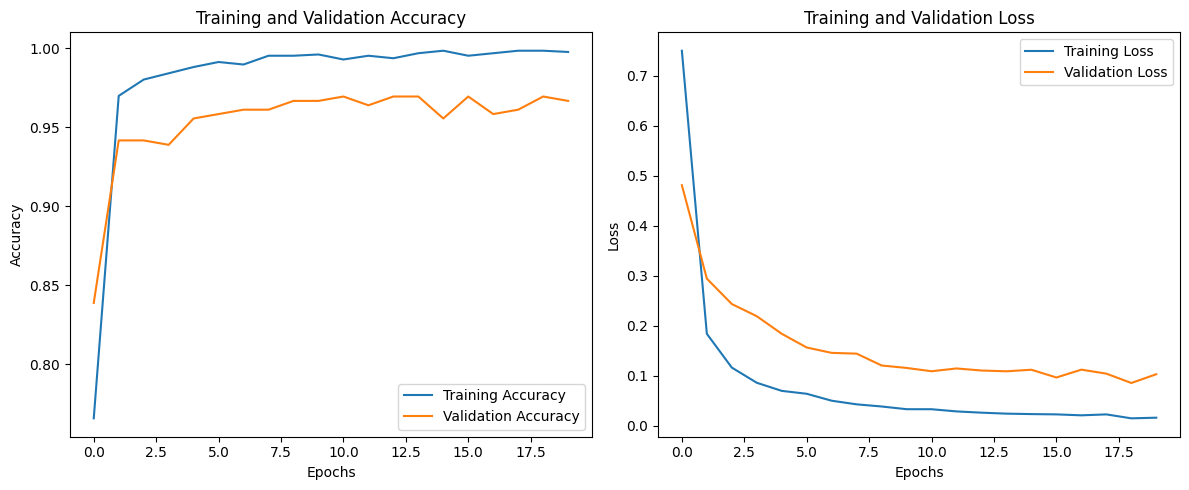

In [6]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function
plot_history(history)

In [7]:
# Evaluate on the test dataset
print("--- Final Evaluation on Test Set ---")
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

--- Final Evaluation on Test Set ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9897 - loss: 0.0403
Test Accuracy: 98.33%
Test Loss: 0.0477


In [8]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


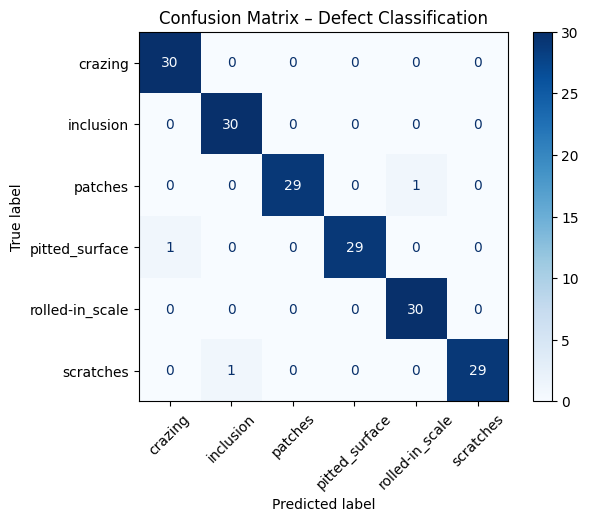


Classification Report:

                 precision    recall  f1-score   support

        crazing       0.97      1.00      0.98        30
      inclusion       0.97      1.00      0.98        30
        patches       1.00      0.97      0.98        30
 pitted_surface       1.00      0.97      0.98        30
rolled-in_scale       0.97      1.00      0.98        30
      scratches       1.00      0.97      0.98        30

       accuracy                           0.98       180
      macro avg       0.98      0.98      0.98       180
   weighted avg       0.98      0.98      0.98       180



In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get the true labels from the test dataset
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels, axis=1))

# 2. Get the model's predictions
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Define the class names (using the variable we saved earlier)
class_names = sorted(os.listdir(f"{DATA_ROOT}/train"))

# 4. Create the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 5. Plot the Confusion Matrix
class_names = classes

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix – Defect Classification")
plt.show()

# 6. Print the Detailed Report (Precision, Recall, F1)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


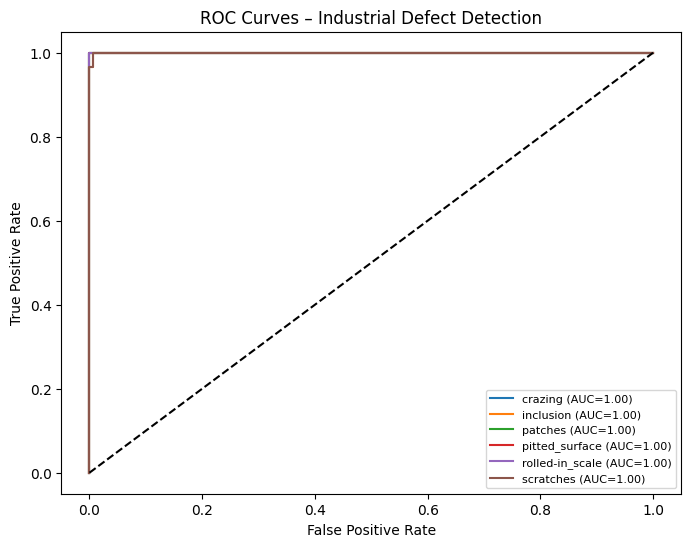

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

plt.figure(figsize=(8, 6))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i],
                            [p[i] for p in model.predict(test_ds)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Industrial Defect Detection")
plt.legend(fontsize=8)
plt.show()


In [23]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


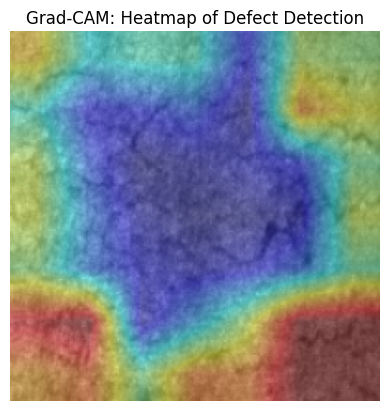

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # 1. Identify the layers we need
    base_model = model.get_layer("mobilenetv2_1.00_224")
    last_conv_layer = base_model.get_layer(last_conv_layer_name)

    # 2. Build a sub-model that reaches the convolutional layer
    inner_model = tf.keras.models.Model([base_model.input], [last_conv_layer.output, base_model.output])

    # 3. Prepare the image (Manual Rescaling)
    rescaled_img = model.get_layer('rescaling')(img_array)

    with tf.GradientTape() as tape:
        # WATCH the rescaled image
        tape.watch(rescaled_img)

        # Get conv outputs and the base model's features
        conv_outputs, base_preds = inner_model(rescaled_img)

        x = model.get_layer('global_average_pooling2d')(base_preds)
        x = model.get_layer('dropout')(x)
        predictions = model.get_layer('dense')(x)

        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # 4. Calculate gradients - this should no longer be None
    grads = tape.gradient(loss, conv_outputs)

    if grads is None:
        raise ValueError("Gradients are None. Check if the layers are connected correctly.")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# --- Visualization Logic ---
for images, labels in test_ds.take(1):
    img = images[0]
    img_array = tf.expand_dims(img, axis=0)

heatmap = make_gradcam_heatmap(img_array, model, "Conv_1")

# Convert image to 0-255 for display
img_np = img.numpy()
if img_np.max() <= 1.0: img_np = img_np * 255
img_np = img_np.astype("uint8")

heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
heatmap = np.uint8(255 * heatmap)
overlay = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_np, 0.6, overlay, 0.4, 0)

plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM: Heatmap of Defect Detection")
plt.show()